In [1]:
import matplotlib.pyplot as plt
import numpy as np
from random import random

from society.agent import Agent, TrainableAgent
from society.simulations.weighted import WeightedNetworkSimulation
from society.strategies.gameplay.constant import AllC, AllD
from society.strategies.gameplay.random import RandomGameplayStrategy
from society.strategies.gameplay.tft import TitForTat
from society.strategies.gameplay.qlearning import TabularQLearningGameplayStrategy
from society.visualisation.network import *
from society.action import Action

plt.rcParams["figure.figsize"] = (10, 6)

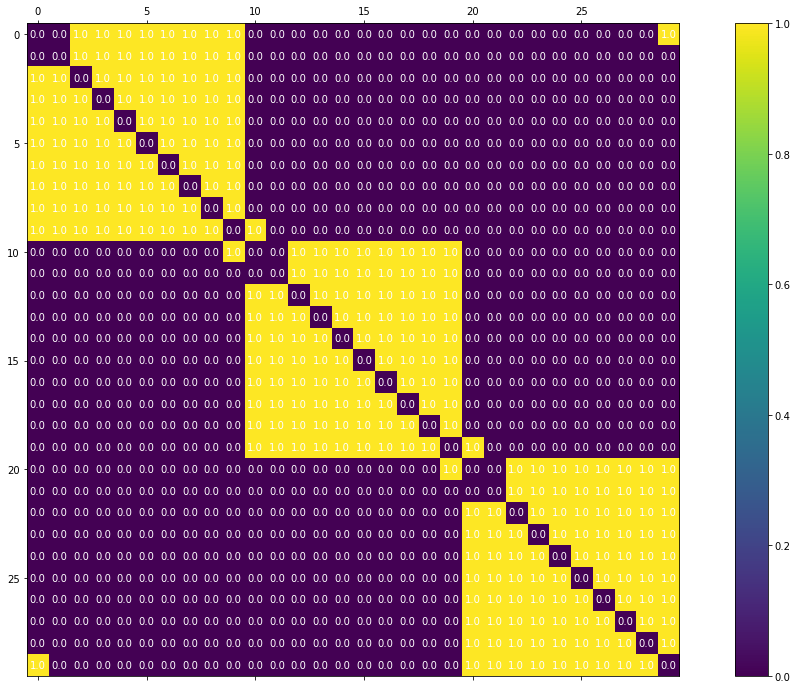

In [2]:
POPULATION = 30
agents = [
    Agent(None, TabularQLearningGameplayStrategy(lookback=3), i, POPULATION)
    for i in range(POPULATION)
]

# for i in range(1, 9):
#     agents[i] = Agent(None, TitForTat(), i, POPULATION)

G = nx.connected_caveman_graph(3, 10)

weights_matrix = np.zeros((POPULATION, POPULATION))
for u, v, d in G.edges(data=True):
    weights_matrix[u, v] = weights_matrix[v, u] = 1.0
    try:
        d["weight"] = weights_matrix[u, v]
    except:
        d["weight"] = 0

plot_matrix(weights_matrix, digits=2, figsize=(20, 12))

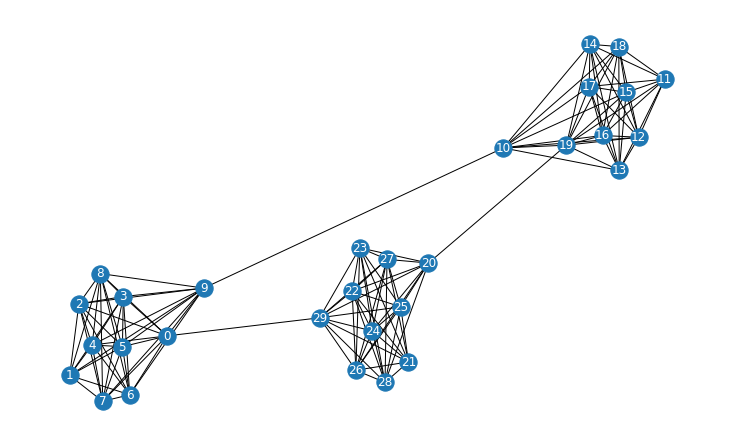

In [3]:
nx.draw(G, pos=nx.spring_layout(G), font_color="white", with_labels=True)

In [4]:
sim = WeightedNetworkSimulation(agents, weights_matrix)
sim.reset()

for i in range(10000):
    sim.play_round()


[(22, 67824), (0, 66965), (6, 64119), (24, 62255), (18, 62212), (19, 62197), (29, 60951), (16, 59756), (27, 58640), (15, 58341), (12, 58321), (9, 58073), (17, 57913), (13, 57904), (14, 57827), (10, 57245), (3, 56000), (4, 55651), (8, 55048), (1, 54614), (2, 54603), (7, 54448), (5, 54249), (11, 54236), (23, 54163), (20, 53986), (26, 53659), (28, 53479), (25, 53412), (21, 50732)]


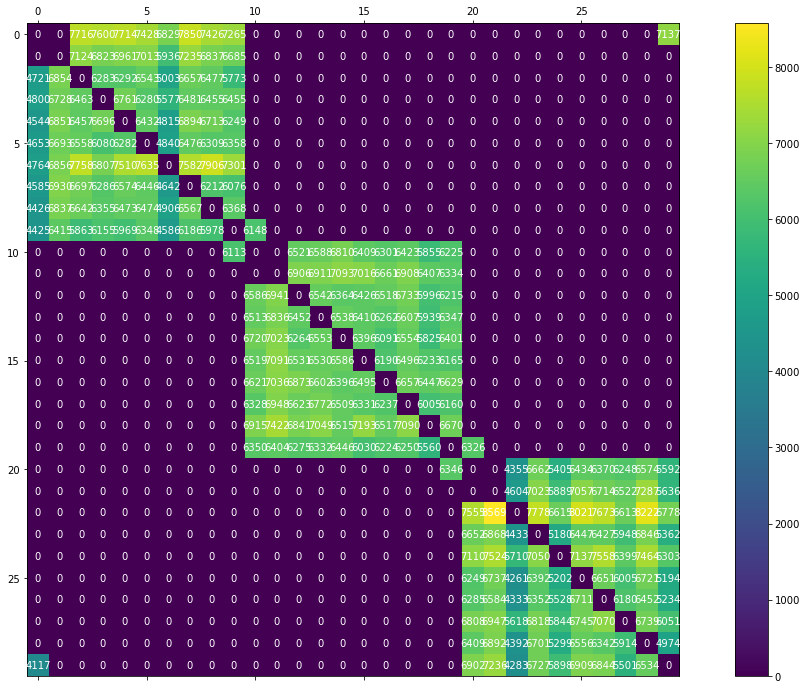

In [5]:
returns_matrix = [[sum(r) if len(r) > 0 else 0 for r in agent] for agent in sim.rewards]
ranked_partners = sorted([(i, sum(returns_matrix[i])) for i in range(POPULATION)], key=lambda x: x[1], reverse=True)
print(ranked_partners)

plot_matrix(returns_matrix, figsize=(20, 12))

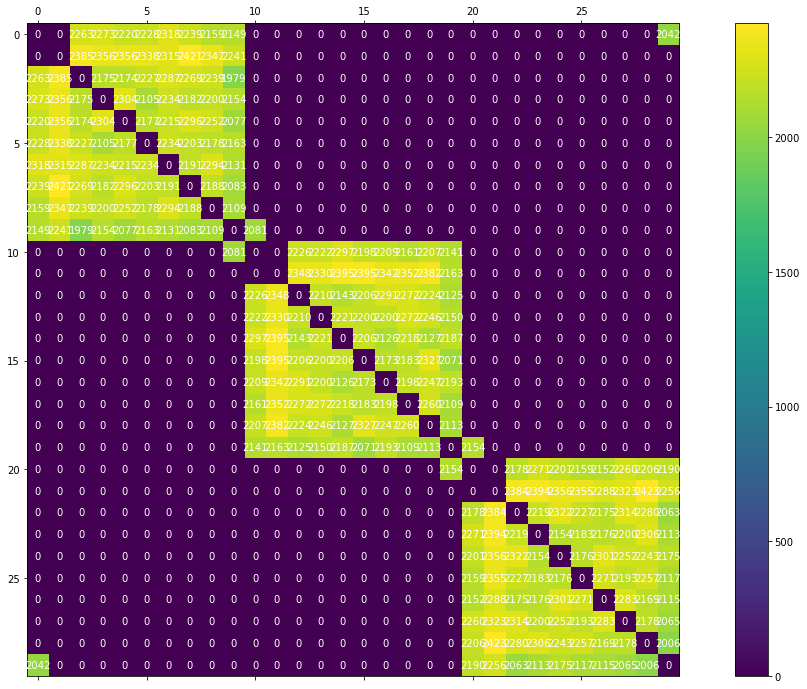

In [6]:
frequency_matrix = [[len(r) for r in agent] for agent in sim.rewards]

plot_matrix(frequency_matrix, figsize=(20, 12))

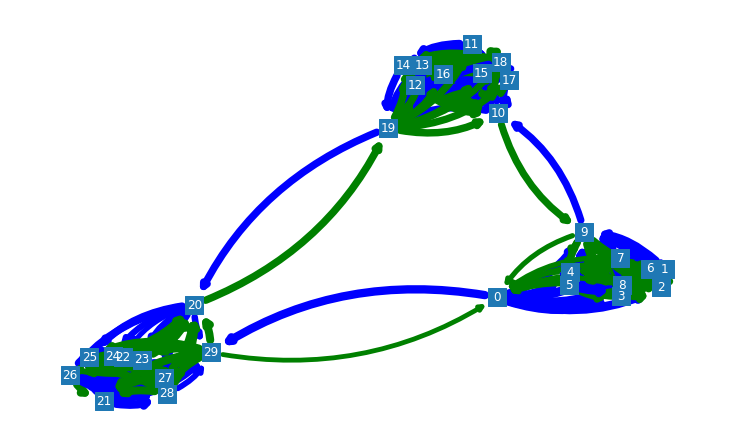

In [7]:
dg = nx.MultiDiGraph(G)

for u, v, d in dg.edges(data=True):
    try:
        d["weight"] = returns_matrix[u][v]
    except:
        d["weight"] = 0

plot_graph_spring(dg)

In [8]:
nx.drawing.nx_pydot.write_dot(dg, "test8.dot")

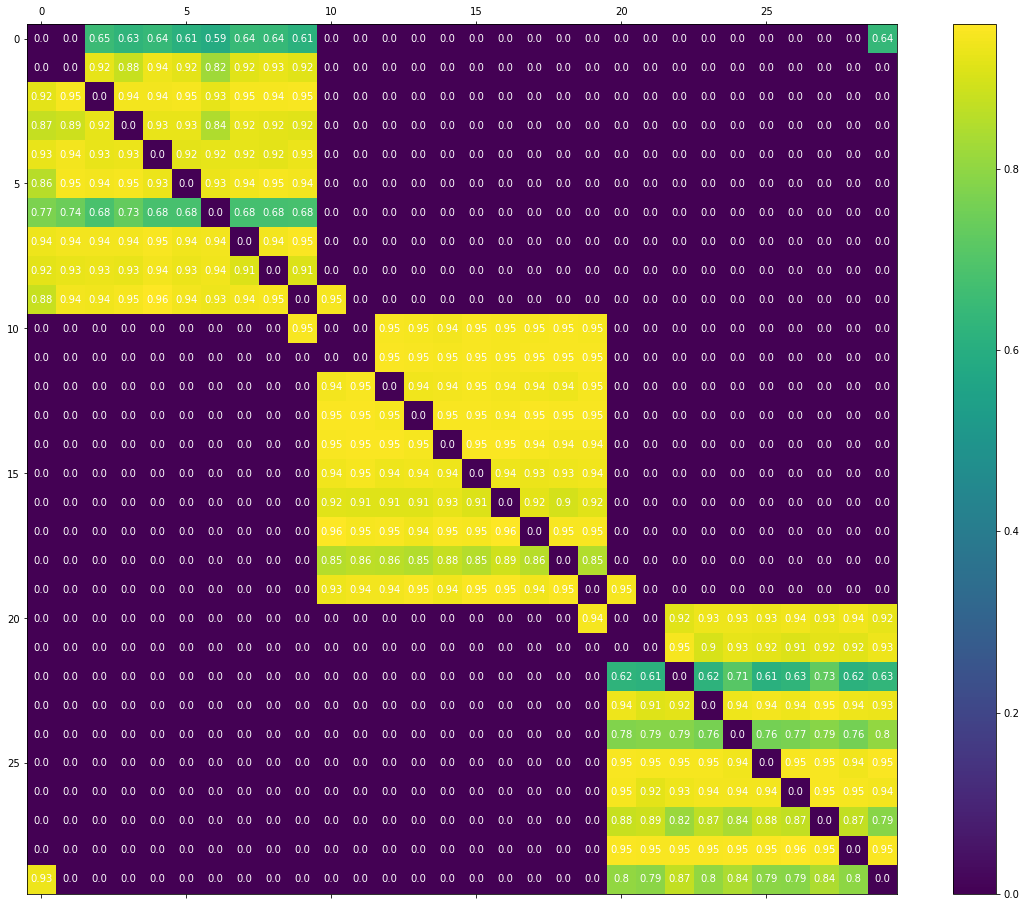

In [9]:
cooperativeness_matrix = [[r.count(Action.COOPERATE) / len(r) if r else 0 for r in agent] for agent in sim.histories]

plot_matrix(cooperativeness_matrix, figsize=(20, 16), digits=2)

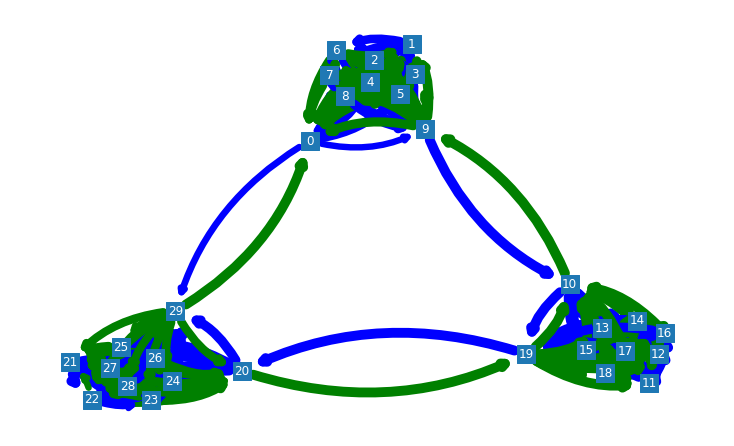

In [10]:
cooperativeness_graph = nx.MultiDiGraph(G)

for u, v, d in cooperativeness_graph.edges(data=True):
    try:
        d["weight"] = sim.histories[u][v].count(Action.COOPERATE) / len(sim.histories[u][v])
    except:
        d["weight"] = 0

plot_graph_spring(cooperativeness_graph)

nx.drawing.nx_pydot.write_dot(dg, "test8-coop.dot")

In [11]:
policy = np.zeros((4, 4, 4))

for agent in agents:
    policy += agent.gameplay_strategy._q_table.argmax(axis=-1)

policy /= len(agents)

policy

array([[[0.23333333, 0.06666667, 0.03333333, 0.06666667],
        [0.13333333, 0.16666667, 0.13333333, 0.06666667],
        [0.06666667, 0.03333333, 0.1       , 0.03333333],
        [0.03333333, 0.13333333, 0.06666667, 0.1       ]],

       [[0.06666667, 0.03333333, 0.13333333, 0.03333333],
        [0.1       , 0.13333333, 0.1       , 0.        ],
        [0.06666667, 0.13333333, 0.03333333, 0.        ],
        [0.03333333, 0.        , 0.03333333, 0.        ]],

       [[0.06666667, 0.03333333, 0.03333333, 0.1       ],
        [0.03333333, 0.16666667, 0.03333333, 0.03333333],
        [0.03333333, 0.13333333, 0.03333333, 0.06666667],
        [0.16666667, 0.        , 0.03333333, 0.        ]],

       [[0.13333333, 0.03333333, 0.06666667, 0.03333333],
        [0.03333333, 0.13333333, 0.        , 0.03333333],
        [0.06666667, 0.        , 0.03333333, 0.03333333],
        [0.13333333, 0.03333333, 0.03333333, 0.        ]]])

In [12]:
actions = ["(C, C)", "(C, D)", "(D, C)", "(D, D)"]

for i, a in enumerate(actions):
    for j, b in enumerate(actions):
        for k, c in enumerate(actions):
            print(f"{a:<8} {b:<8} {c:<8} => {('C', 'D')[round(policy[i, j, k])]:<4} [{round(policy[i, j, k], 5):05f}]")

(C, C)   (C, C)   (C, C)   => C    [0.233330]
(C, C)   (C, C)   (C, D)   => C    [0.066670]
(C, C)   (C, C)   (D, C)   => C    [0.033330]
(C, C)   (C, C)   (D, D)   => C    [0.066670]
(C, C)   (C, D)   (C, C)   => C    [0.133330]
(C, C)   (C, D)   (C, D)   => C    [0.166670]
(C, C)   (C, D)   (D, C)   => C    [0.133330]
(C, C)   (C, D)   (D, D)   => C    [0.066670]
(C, C)   (D, C)   (C, C)   => C    [0.066670]
(C, C)   (D, C)   (C, D)   => C    [0.033330]
(C, C)   (D, C)   (D, C)   => C    [0.100000]
(C, C)   (D, C)   (D, D)   => C    [0.033330]
(C, C)   (D, D)   (C, C)   => C    [0.033330]
(C, C)   (D, D)   (C, D)   => C    [0.133330]
(C, C)   (D, D)   (D, C)   => C    [0.066670]
(C, C)   (D, D)   (D, D)   => C    [0.100000]
(C, D)   (C, C)   (C, C)   => C    [0.066670]
(C, D)   (C, C)   (C, D)   => C    [0.033330]
(C, D)   (C, C)   (D, C)   => C    [0.133330]
(C, D)   (C, C)   (D, D)   => C    [0.033330]
(C, D)   (C, D)   (C, C)   => C    [0.100000]
(C, D)   (C, D)   (C, D)   => C   

In [13]:
best_agent = agents[ranked_partners[0][0]]

best_policy = best_agent.gameplay_strategy._q_table.argmax(axis=-1)

for i, a in enumerate(actions):
    for j, b in enumerate(actions):
        for k, c in enumerate(actions):
            print(f"{a:<8} {b:<8} {c:<8} => {('C', 'D')[round(best_policy[i, j, k])]:<4}")


(C, C)   (C, C)   (C, C)   => D   
(C, C)   (C, C)   (C, D)   => C   
(C, C)   (C, C)   (D, C)   => C   
(C, C)   (C, C)   (D, D)   => C   
(C, C)   (C, D)   (C, C)   => D   
(C, C)   (C, D)   (C, D)   => C   
(C, C)   (C, D)   (D, C)   => C   
(C, C)   (C, D)   (D, D)   => C   
(C, C)   (D, C)   (C, C)   => D   
(C, C)   (D, C)   (C, D)   => C   
(C, C)   (D, C)   (D, C)   => C   
(C, C)   (D, C)   (D, D)   => C   
(C, C)   (D, D)   (C, C)   => C   
(C, C)   (D, D)   (C, D)   => C   
(C, C)   (D, D)   (D, C)   => C   
(C, C)   (D, D)   (D, D)   => D   
(C, D)   (C, C)   (C, C)   => C   
(C, D)   (C, C)   (C, D)   => C   
(C, D)   (C, C)   (D, C)   => C   
(C, D)   (C, C)   (D, D)   => C   
(C, D)   (C, D)   (C, C)   => C   
(C, D)   (C, D)   (C, D)   => C   
(C, D)   (C, D)   (D, C)   => C   
(C, D)   (C, D)   (D, D)   => C   
(C, D)   (D, C)   (C, C)   => C   
(C, D)   (D, C)   (C, D)   => C   
(C, D)   (D, C)   (D, C)   => C   
(C, D)   (D, C)   (D, D)   => C   
(C, D)   (D, D)   (C

In [14]:
best_agent.gameplay_strategy._q_table

array([[[[1.88734279e+02, 2.06135127e+02],
         [1.86902061e+02, 7.82450420e+01],
         [2.09598385e+02, 1.46872477e+02],
         [1.93308825e+02, 2.75819099e+01]],

        [[8.36423076e+01, 1.91519353e+02],
         [1.25658223e+02, 1.96630214e+00],
         [1.47641669e+02, 1.05543044e+00],
         [1.05835145e+02, 8.32559040e+00]],

        [[1.92631873e+02, 2.07241402e+02],
         [1.88059566e+02, 1.82926581e+01],
         [1.74215245e+02, 6.75448893e+01],
         [4.90922347e+01, 2.23793933e+00]],

        [[1.91849179e+02, 1.53126834e+02],
         [1.19272235e+02, 5.00000000e-01],
         [1.10356070e+02, 1.40717969e+00],
         [0.00000000e+00, 5.36432157e+00]]],


       [[[2.01746619e+02, 1.30428571e+02],
         [1.73306943e+02, 4.60711159e+01],
         [2.02552512e+02, 6.17389702e+01],
         [1.91347416e+02, 2.53525837e+01]],

        [[1.72568348e+02, 5.47196910e+01],
         [5.00953224e+01, 5.00000000e-01],
         [3.15516401e+01, 0.00000000e+00],

In [15]:
worst_agent = agents[ranked_partners[-1][0]]

worst_policy = worst_agent.gameplay_strategy._q_table.argmax(axis=-1)

for i, a in enumerate(actions):
    for j, b in enumerate(actions):
        for k, c in enumerate(actions):
            print(f"{a:<8} {b:<8} {c:<8} => {('C', 'D')[round(worst_policy[i, j, k])]:<4}")


(C, C)   (C, C)   (C, C)   => C   
(C, C)   (C, C)   (C, D)   => C   
(C, C)   (C, C)   (D, C)   => D   
(C, C)   (C, C)   (D, D)   => C   
(C, C)   (C, D)   (C, C)   => C   
(C, C)   (C, D)   (C, D)   => C   
(C, C)   (C, D)   (D, C)   => C   
(C, C)   (C, D)   (D, D)   => C   
(C, C)   (D, C)   (C, C)   => C   
(C, C)   (D, C)   (C, D)   => C   
(C, C)   (D, C)   (D, C)   => C   
(C, C)   (D, C)   (D, D)   => C   
(C, C)   (D, D)   (C, C)   => C   
(C, C)   (D, D)   (C, D)   => C   
(C, C)   (D, D)   (D, C)   => C   
(C, C)   (D, D)   (D, D)   => C   
(C, D)   (C, C)   (C, C)   => C   
(C, D)   (C, C)   (C, D)   => C   
(C, D)   (C, C)   (D, C)   => C   
(C, D)   (C, C)   (D, D)   => C   
(C, D)   (C, D)   (C, C)   => C   
(C, D)   (C, D)   (C, D)   => D   
(C, D)   (C, D)   (D, C)   => C   
(C, D)   (C, D)   (D, D)   => C   
(C, D)   (D, C)   (C, C)   => C   
(C, D)   (D, C)   (C, D)   => C   
(C, D)   (D, C)   (D, C)   => C   
(C, D)   (D, C)   (D, D)   => C   
(C, D)   (D, D)   (C